## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


---

## 1: Introduction

## 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 212 kB 25.6 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

# display the accuracy and val_accuracy, loss and val_loss
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# calculate confusion matrix
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
dataset = nlp.load_dataset("emotion")

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
#separate dataset
train = dataset["train"]
val = dataset["validation"]
test = dataset["test"]

In [ ]:
def get_tweet(data):
  tweets = [x["text"] for x in data]
  labels = [x["label"]for x in data]

  return tweets, labels

In [ ]:
tweets, labels = get_tweet(train)

In [ ]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
#convert words to numbers

In [ ]:
tokenizer = Tokenizer(num_words = 10000, oov_token="<UNK>")
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [ ]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

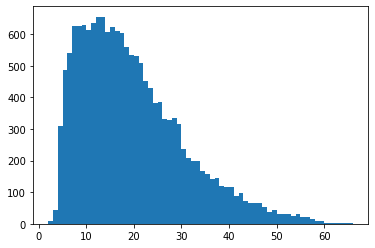

In [ ]:
#check length of tweets
lengths = [len(t.split(" ")) for t in tweets]
plt.hist(lengths, bins= len(set(lengths)))
plt.show()

In [ ]:
# no tweets after 60, very few less than 10

maxlen=50 #to trunctate the long tweets
#pad tweets to not be longer

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating= "post", padding= "post", maxlen= maxlen) # create a list of padded sequences where each sequence length should be equal to 50


  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
#check first tweet
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
# take a look at labels
classes = set(labels)
print(classes)

{'love', 'anger', 'fear', 'joy', 'sadness', 'surprise'}


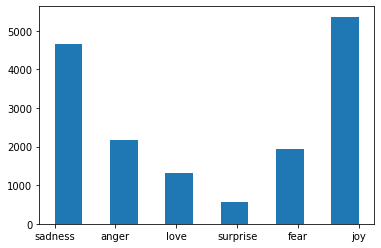

In [ ]:
plt.hist(labels, bins=11)
plt.show()

#class imbalanced problem

In [ ]:
classes_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v, k) for k, v in classes_to_index.items())

In [ ]:
classes_to_index

{'anger': 1, 'fear': 2, 'joy': 3, 'love': 0, 'sadness': 4, 'surprise': 5}

In [ ]:
index_to_class

{0: 'love', 1: 'anger', 2: 'fear', 3: 'joy', 4: 'sadness', 5: 'surprise'}

In [ ]:
#convert names to ids

names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[0])

#4 is sadness

4


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences = True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                    tf.keras.layers.Dense(6, activation = "softmax")
                                    ])

#each word represented as a 16 dimensional vector
#6 as we have 6 classes of emotions

model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "adam",
    metrics =["accuracy"]

)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweets, val_labels = get_tweet(val)
val_seq= get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 4)

In [ ]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor= "val_accuracy", patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 29s 59ms/step - loss: 1.2835 - accuracy: 0.4933 - val_loss: 0.7952 - val_accuracy: 0.7055
Epoch 2/20
500/500 [==============================] - 28s 56ms/step - loss: 0.5813 - accuracy: 0.7956 - val_loss: 0.6028 - val_accuracy: 0.7935
Epoch 3/20
500/500 [==============================] - 28s 55ms/step - loss: 0.3591 - accuracy: 0.8836 - val_loss: 0.4829 - val_accuracy: 0.8520
Epoch 4/20
500/500 [==============================] - 27s 55ms/step - loss: 0.2402 - accuracy: 0.9260 - val_loss: 0.4555 - val_accuracy: 0.8585
Epoch 5/20
500/500 [==============================] - 27s 54ms/step - loss: 0.1764 - accuracy: 0.9471 - val_loss: 0.4300 - val_accuracy: 0.8745
Epoch 6/20
500/500 [==============================] - 26s 52ms/step - loss: 0.1367 - accuracy: 0.9603 - val_loss: 0.4049 - val_accuracy: 0.8785
Epoch 7/20
500/500 [==============================] - 27s 53ms/step - loss: 0.1165 - accuracy: 0.9659 - val_loss: 0.4152 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

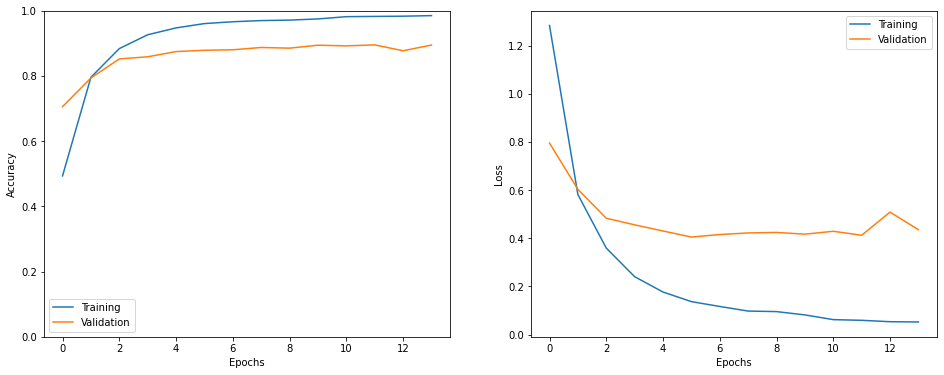

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model. evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 20ms/step - loss: 0.3946 - accuracy: 0.8900


In [ ]:
i = random.randint(0, len(test_labels)-1)

print("Sentence: ", test_tweets[i])
print("Emotion: ", index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis= 0))[0]
pred_class = index_to_class[np.argmax(p).astype("uint8")]

print("Predicted emotion: ", pred_class)

Sentence:  i think they have always been proponents of the idea and it is just slightly possible that his feelings for a particularly charming new england girl have brought him around to their way of thinking
Emotion:  joy
Predicted emotion:  joy


In [ ]:
#predict on the test seq
preds = np.argmax(model.predict(test_seq), axis=1)

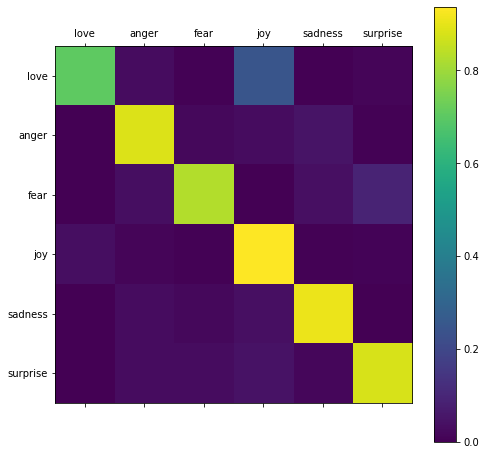

In [ ]:
#show confusion matrix
show_confusion_matrix(test_labels, preds, list(classes))

#joy and love, and love